In [51]:
"""
This is a notebook to walkthrough the process of clustering the combined data.
"""

import geopandas as gpd
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap

from sklearn.preprocessing import StandardScaler

# Threshold for determining high quality clusters - This will be used to filter
# clusters based on the mean probability of points in each cluster.
# This is a threshold I set after some experimentation. It can be adjusted
# based on the clustering results.
PROBABILITY_THRESHOLD = 0.99

In [52]:
# Import data from previous notebook
df = pd.read_pickle("experimental_data/merged_data_2022-07-21_to_2025-07-20.pkl")
print(df.head())

  dispatch_date       dispatch_time             address_block        lat  \
0    2025-05-02 2025-07-21 23:44:00       1100 BLOCK S 4TH ST  39.934248   
2    2025-05-12 2025-07-21 21:04:00  5100 BLOCK LANCASTER AVE  39.977061   
3    2025-04-23 2025-07-21 18:32:00      1700 BLOCK N 32ND ST  39.983588   
4    2025-04-24 2025-07-21 00:47:00   1300 BLOCK W Venango St  40.007425   
5    2025-02-26 2025-07-21 20:16:00       400 BLOCK N 35TH ST  39.961642   

         lon  district_01  district_02  district_03  district_05  district_06  \
0 -75.150833        False        False         True        False        False   
2 -75.226406        False        False        False        False        False   
3 -75.186199        False        False        False        False        False   
4 -75.149843        False        False        False        False        False   
5 -75.192723        False        False        False        False        False   

   ...  max_temp_f  min_temp_f  pop_total  income_median

The first significant step is to scale our data, as clustering is based on distance. This is to avoid
features that are naturally greater in range, take higher importance/precedence when clustered.

In [53]:
# Make a copy of the original dataframe, where all the preprocessing is done on
df_to_scale = df.copy()

# Initialize StandardScaler and config it to output a DataFrame
scaler = StandardScaler()
scaler.set_output(transform="pandas")

# Extract the columns to scale
numeric_cols = df_to_scale.select_dtypes(include=np.number).columns.tolist()
# NOTE: I do not want to scale the sinusoidal features as they are already in the desired range
cols_to_scale = [col for col in numeric_cols if "_sin" not in col and "_cos" not in col]

# Fit and transform the data
df_to_scale[cols_to_scale] = scaler.fit_transform(df_to_scale[cols_to_scale])

# Print the scaled data as sanity check
print(df_to_scale.head())

  dispatch_date       dispatch_time             address_block       lat  \
0    2025-05-02 2025-07-21 23:44:00       1100 BLOCK S 4TH ST -1.408107   
2    2025-05-12 2025-07-21 21:04:00  5100 BLOCK LANCASTER AVE -0.467133   
3    2025-04-23 2025-07-21 18:32:00      1700 BLOCK N 32ND ST -0.323676   
4    2025-04-24 2025-07-21 00:47:00   1300 BLOCK W Venango St  0.200224   
5    2025-02-26 2025-07-21 20:16:00       400 BLOCK N 35TH ST -0.806029   

        lon  district_01  district_02  district_03  district_05  district_06  \
0 -0.066910        False        False         True        False        False   
2 -1.267523        False        False        False        False        False   
3 -0.628769        False        False        False        False        False   
4 -0.051177        False        False        False        False        False   
5 -0.732402        False        False        False        False        False   

   ...  max_temp_f  min_temp_f  pop_total  income_median  median_age

Now, the data is ready for applying UMAP. This is a non-linear dimensionality
reduction algorithm, based on topology (allowing it to capture those non-linear patterns). This is
used, as clustering our data with over 80 columns can easily lead to the curse of dimensionality,
leading to much higher computational time and overfitting.

However, some columns in the data cannot be used here, so I drop them - They will be re-added later
as part of the final analysis.

In [54]:
columns_to_drop = [
    "dispatch_date",
    "dispatch_time",
    "address_block",
    "dispatch_date_dt",
    "geometry",
    "tract_id",
]

df_umap_ready = df_to_scale.drop(columns=columns_to_drop)

In [55]:
# Initialize UMAP. I'll stick with some static parameters for this experimental notebook. Ideally, I
# would use MLFlow to optimize these parameters in the formal data pipeline.
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)

# Fit and transform the data
df_embedding = reducer.fit_transform(df_umap_ready).astype("float64")

c:\Users\kevin\OneDrive\Documents\Python\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


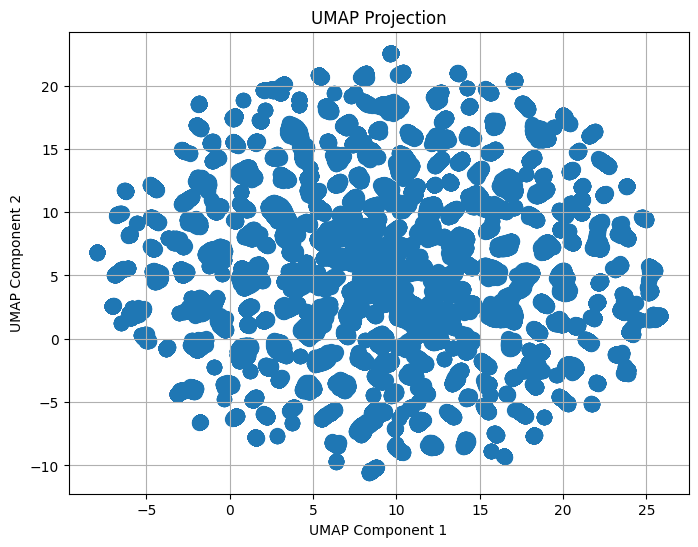

In [56]:
# Visualize the embedded data from UMAP
plt.figure(figsize=(8, 6))
plt.scatter(df_embedding[:, 0], df_embedding[:, 1], s=100)
plt.title("UMAP Projection")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.show()

From this, it's clear that there are lots of small clusters. Past that, it's hard to distinquish between them though.

At this point, I apply HDBSCAN to cluster this embedded data, to hopefully
shine some further light into the data.

In [57]:
# Initialize HDBSCAN object, again with some starting parameters for this
# notebook
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5000, min_samples=40, gen_min_span_tree=True
)

# Fit the HDBSCAN model with the UMAP embedded data
clusterer.fit(df_embedding)

c:\Users\kevin\OneDrive\Documents\Python\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kevin\OneDrive\Documents\Python\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,min_cluster_size,5000
,min_samples,40
,cluster_selection_epsilon,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)
,approx_min_span_tree,True


Now, I want to evaluate how well the clustering is. This is a bit open ended in nature, given that there is no pre-defined "true" label for the cluster.
Instead, I use a combination of 3 metrics to calculate a common score of sorts.

The first is the DBCV score. This measures how well points within each cluster
are clustered together, and how well separated individual clusters are. This
has a range of -1 to 1, with 1 having perfect clusters, 0 suggesting an ambigiuous cluster structure, and -1 indicating points likely being assigned to the wrong cluster - Ideal scores are positive as close to 1.

The second is the proportion of noise. This is just the proportion of our data that was considered an outlier by HDBSCAN. Lower is better, of course.

The third is the number of clusters. HDBSCAN is unique in that it will automatically determine the best number of clusters (compared to other algorithms where this is pre-defined), but we do not want to have a ton of clusters, which is quite possible with the scale of the data being used. To some degree, this wants to be minimized.

I define a custom metric combining all three as follows:
$$
\text{Score}_{\text{custom}} = (\text{Score}_{\text{DBCV}} - P_{\text{noise}}) - \alpha \cdot \ln(1 + N_{\text{clusters}})
$$
This subtracts the DBCV score with the proportion of noise, and then subtracts by a log transformation of the # of clusters. Given the range of all the other metrics, the range of my new custom metric is roughly negative infinity to 0.89 (this upper bound is with a DBCV score of 1, noise proportion of 0, and 2 clusters). In broader terms, the higher this custom score is, the better.

In [ ]:
# Extract the cluster labels from the model
labels = clusterer.labels_

# Get DBCV score
dbcv_score = clusterer.relative_validity_

# Get noise proportion
noise_prop = np.sum(labels == -1) / len(labels)

# Get # of clusters
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Define a custom score combining the DBCV score, proportion of noise, and
# number of clusters
custom_score = (dbcv_score - noise_prop) - (0.1 * np.log1p(num_clusters))
print(f"Custom score (higher is better): {custom_score}")

Custom score (higher is better): 0.3271346441714664


Overall, this is not too bad. Given the scale of the crime data I am using, I cannot realistically expect this to be very high, but at least for the static copy of the data stored from the previous notebook, this is fairly decent! More work can be done of course, but that's a whole other can of worms I will not worry about for now.

From here, I try to highlight each cluster with the UMAP embedded data.

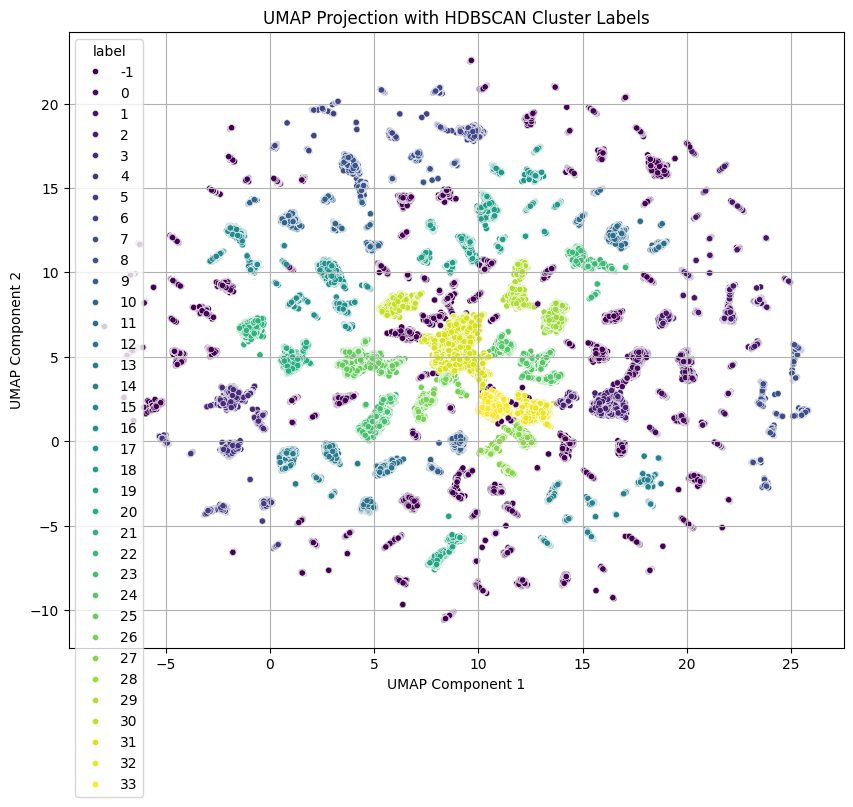

In [59]:
# Add the cluster labels to the UMAP embedded data
df_embedding_labeled = pd.DataFrame(
    df_embedding, columns=["UMAP Component 1", "UMAP Component 2"]
)
df_embedding_labeled["label"] = labels

# Display the UMAP data with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="UMAP Component 1",
    y="UMAP Component 2",
    hue="label",
    data=df_embedding_labeled,
    palette="viridis",
    s=20,
    legend="full",
)
plt.title("UMAP Projection with HDBSCAN Cluster Labels")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.show()

Admittedly, this plot is not the best. Since there are so many clusters, it is hard to distinquish between them. What can be seen though, is that many of the smaller clusters (or individual clusters) do group up accordingly. This is good to verify that HDBSCAN is indeed working (e.g. having dots without any pattern of the color would be more concerning).

However, this plot does highlight a big issue: The high amount of clusters. I chose to stick with a 
color gradiant to highlight each crime based on the cluster label, but clearly this is not ideal.
HDBSCAN is good in that I do not need to specify the # of clusters (so it determines that number on
its own in a smart way), but it certainly does not mean that an "absurdly" large number of clusters
can never be achieved.

As such, I decided it would be more imformative to simply subset to the top clusters with the 
best "quality." This is done with the probability scores for each point. Each crime observation is
assigned a probability that effectively shows how well it fits within the assigned cluster. So, I 
take the mean of this metric for each cluster, and pick the clusters with a mean probability of 
0.95 (what I chose to set `PROBABILITY_THRESHOLD` to).

The downside of this is that not all the data will obviously be kept, but I mainly want to highlight
the most prominent (and to some degree, the most confident) clusters. It is worthwhile to keep in 
mind that not all data is kept regardless.

In [60]:
# Get the cluster probabilities for each observation
probs = clusterer.probabilities_

# Create a DataFrame with labels and probabilities
prob_df = pd.DataFrame({'label': labels, 'probability': probs})

# Exclude noise
prob_df = prob_df[(prob_df['label'] != -1)]

# Compute mean probability for each cluster
mean_probs = prob_df.groupby('label')['probability'].mean().sort_values(ascending=False)

# Filter clusters with mean probability over the threshold and sort descending
high_quality_clusters = mean_probs[mean_probs > PROBABILITY_THRESHOLD]
print(high_quality_clusters)

label
4     1.000000
5     1.000000
17    1.000000
12    1.000000
9     1.000000
26    0.999993
29    0.999968
19    0.998371
28    0.997069
Name: probability, dtype: float64


I will reproduce the plot but only with the high quality clusters now, just as a comparison.

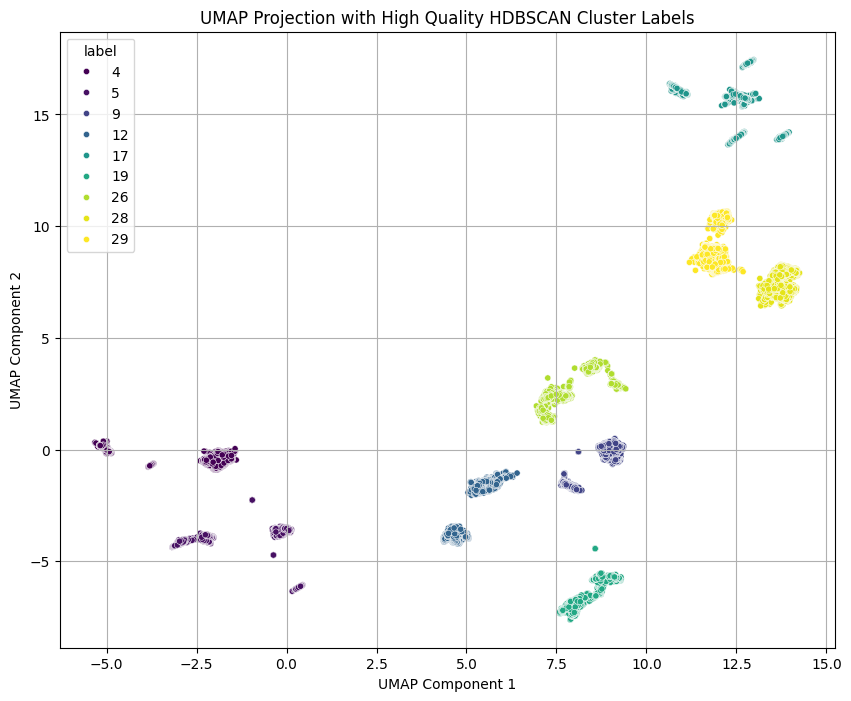

In [61]:
# Assign cluster labels to the embedded data
df_embedding_labeled_hq = df_embedding_labeled[df_embedding_labeled["label"].isin(high_quality_clusters.index)]

# Plot the filtered embedded data with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="UMAP Component 1",
    y="UMAP Component 2",
    hue="label",
    data=df_embedding_labeled_hq,
    palette="viridis",
    s=20,
    legend="full",
)
plt.title("UMAP Projection with High Quality HDBSCAN Cluster Labels")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.show()

Now we can see more distinct clusters!

The final task now, is just adding the cluster labels back to the original dataframe for the 
observations in one of these high quality clusters.

In [62]:
# Adding a new cluster label column to the original dataframe, `df`, without the
# scaled data. This is for the final bit of EDA, and we do not want to perform
# that with the scaled data.

df["cluster_label"] = labels

# Subset to only the high quality clusters
df = df[df["cluster_label"].isin(high_quality_clusters.index)]
print(df.head())
print(df.shape)

   dispatch_date       dispatch_time             address_block        lat  \
21    2025-04-13 2025-07-21 01:11:00  2000 BLOCK N MARSHALL ST  39.981997   
32    2025-04-23 2025-07-21 15:50:00   5500 BLOCK LANSDOWNE AV  39.977063   
35    2025-02-26 2025-07-21 19:51:00       5000 BLOCK HAZEL AV  39.950778   
37    2025-04-12 2025-07-21 12:12:00       5700 BLOCK HAZEL AV  39.952895   
39    2025-03-23 2025-07-21 20:42:00   1400 BLOCK ELLSWORTH ST  39.936830   

          lon  district_01  district_02  district_03  district_05  \
21 -75.145175        False        False        False        False   
32 -75.231953        False        False        False        False   
35 -75.223260        False        False        False        False   
37 -75.237858        False        False        False        False   
39 -75.168614        False        False        False        False   

    district_06  ...  min_temp_f  pop_total  income_median  median_age  \
21        False  ...        42.0     5302.0     

In [63]:
# Save the data with the cluster labels (doing both .csv and .pkl for flexability)

filepath_pkl = f"experimental_data/labeled_merged_data_2022-07-21_to_2025-07-20.pkl"
filepath_csv = f"experimental_data/labeled_merged_data_2022-07-21_to_2025-07-20.csv"
df.to_pickle(filepath_pkl)
df.to_csv(filepath_csv)